# Syrtis Demonstration - Martian Environment
# Variations in Heat Loss over a Martian Day

This example shows another feature of Syrtis that allows for rapid calculation of many values - the `DayManager` tool. This initialises and runs a series of simulations for a single habitat geometry, each at a different time of a solar day. `DayManager` thus provides the ability to see how a habitat design will fare across an entire sol, rather than just at a static point in time. It also automatically corrects for atmospheric attenuation, reduced sunlight at higher latitudes and variability in daily temperature.

In [1]:
from syrtis import *
from syrtis.configuration import Configuration
from syrtis.solver import Solver
from syrtis.material import Solid, ConstrainedIdealGas
from syrtis.habitat import Habitat
import numpy as np
import matplotlib.pyplot as plt

### Setup and Configuration
The same geometry as the Mars Direct - Vertical HAB is used. Instead of the generic Martian equator location, the landing point of the Curiosty rover is used - as this allows the use of air/ground temperature measurements from REMS weather station instrument.

In [2]:
# Materials definitions
# The absorbivity of perlite and air are assumed as 0.5 but are not required
aluminium = Solid("Aluminium", 247, 2700, 900, 0.15)
plastic = Solid("Generic plastic", 10, 1300, 1420, 0.5)

internal_air = ConstrainedIdealGas("STP CO2", 101325, 29, 0.71, 10.9e-6, 749, 0.0153)
martian_air = ConstrainedIdealGas("Martian ambient pressure CO2", 580, 44, 0.71, 10.9e-6, 749, 0.0153)

mount_sharp = Configuration("Curiosity landing area, Mount Sharp",
 "constant temperature", 210, 0.2, 0.29, 210, 580, 5, "cross", 90, 90, 590, T_habitat=293)

In [3]:
HAB_vertical = Habitat(orientation="vertical", length=8, endcap_type="flat")

HAB_vertical.create_static_shell(internal_air, 4.400)
HAB_vertical.create_static_shell(aluminium, 4.8e-3)

HAB_vertical.create_static_shell(martian_air, 50e-3, parallel_thermal_resistance=8.5e-5)
# Parallel resistance corresponds to 1% of the cross-section being aluminium

HAB_vertical.create_static_shell(plastic, 12e-3)
HAB_vertical.create_static_shell(martian_air, 50e-3, parallel_thermal_resistance=8.4e-5)

HAB_vertical.create_static_shell(aluminium, 2e-3)

HAB_vertical.create_ground_level(thermal_resistance=1)
# Thermal resistance roughly corresponds to six aluminium landing legs, each 5m long and with 50cm2 area

## DayManager Creation

`DayManager` objects are created for both a winter and summer case, with different values of areocentric longitude. This is an orbital parameter, commonly denoted as $L$ which describes the position of Mars in the orbit. $L=90$ corresponds to midwinter in the Southern hemisphere, $L=270$ corresponds to midsummer. The seasonal variation on minimum and maximum air temperature is taken from the Curiosity REMS instument, retrieved from the Planetary Data Service. $L=270$ data taken from Curiosity Sol 53 and for $L=90$ Sol 554, with a 30-minute moving average used to capture the approximate maximum and minimum temperature of the ground and air.

"Gomez-Elvira, J., Mars Science Laboratory Rover Environmental Monitoring Station RDR Data V1.0, MSL-M-REMS-4-ENVEDR-V1.0, NASA Planetary Data System, 2013."

In [4]:
summer_data = DayManager(HAB_vertical, mount_sharp, 49, 
    atmosphere_tau=0.3, latitude=-4.6, areocentric_longitude=270,
    T_air_max=270, T_air_min=195, T_ground_max=298, T_ground_min=170, time_air_peak=15.3, time_ground_peak=12.2)

winter_data = DayManager(HAB_vertical, mount_sharp, 49, 
    atmosphere_tau=0.3, latitude=-4.6, areocentric_longitude=90,
    T_air_max=250, T_air_min=165, T_ground_max=195, T_ground_min=110, time_air_peak=15.2, time_ground_peak=12.1)

6.309295566504435 18.340704433495564 270 224.8208946109544
6.309295566504435 18.340704433495564 298 160.48031177057348
6.015704433495563 18.634295566504434 250 199.8912347042554
6.015704433495563 18.634295566504434 195 108.27126441633477


Before we examine the solutions, some of the parameters of the daily and seasonal variation can be plotted.

The approximation to daily temperature variation is shown below. Two curves are combined to make this fit - a sinusoidal curve during daylight, which starts at the coldest point of the day (just before sunrise) and continues to sunset. The temperature then drops linearly from sunset to the following sunrise. This is a good fit for the data observed by various spacecraft.

Text(0.5, 1.0, 'Variation of ground and air temperature over midsummer day')

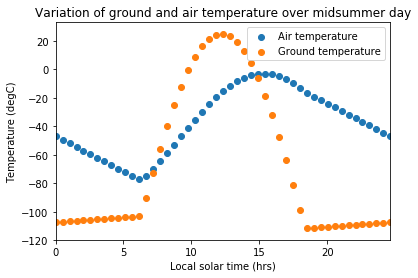

In [5]:
plt.scatter(summer_data.times, [i-273 for i in summer_data.T_airs], label="Air temperature")
plt.scatter(summer_data.times, [i-273 for i in summer_data.T_grounds], label="Ground temperature")

plt.legend()

plt.xlim(0, 24.65)

plt.xlabel("Local solar time (hrs)")
plt.ylabel("Temperature (degC)")
plt.title("Variation of ground and air temperature over midsummer day")

Text(0.5, 1.0, 'Variation of solar altitude between summer and winter')

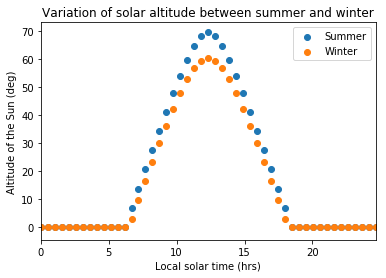

In [6]:
plt.scatter(summer_data.times, summer_data.solar_altitudes, label="Summer")
plt.scatter(winter_data.times, winter_data.solar_altitudes, label="Winter")

plt.legend()

plt.xlim(0, 24.65)

plt.xlabel("Local solar time (hrs)")
plt.ylabel("Altitude of the Sun (deg)")
plt.title("Variation of solar altitude between summer and winter")

Text(0.5, 1.0, 'Variation of solar intensity between summer and winter')

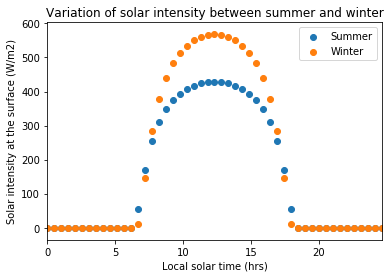

In [7]:
plt.scatter(summer_data.times, summer_data.solar_intensities, label="Summer")
plt.scatter(winter_data.times, winter_data.solar_intensities, label="Winter")

plt.legend()

plt.xlim(0, 24.65)

plt.xlabel("Local solar time (hrs)")
plt.ylabel("Solar intensity at the surface (W/m2)")
plt.title("Variation of solar intensity between summer and winter")

In [8]:
summer_configs, summer_heats, summer_reports = summer_data.run_all_configurations(verbose=True)

winter_configs, winter_heats, summer_reports = winter_data.run_all_configurations(verbose=True)

Text(0.5, 1.0, 'Daily variation in heat loss from habitat, summer and winter')

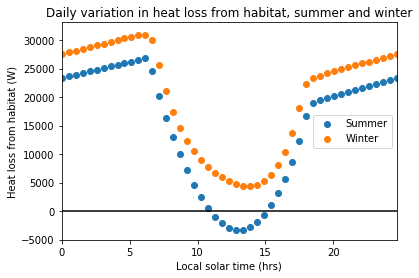

In [13]:
plt.figure(figsize=(6,4))

plt.scatter(summer_data.times, summer_heats, label="Summer")
plt.scatter(winter_data.times, winter_heats, label="Winter")

plt.legend()
plt.axhline(0, color='black')
plt.xlim(0, 24.65)



plt.xlabel("Local solar time (hrs)")
plt.ylabel("Heat loss from habitat (W)")
plt.title("Daily variation in heat loss from habitat, summer and winter")